This tutorial outlines how you can use various callback functions, which allow JAX runtimes to execute Python code on the host. Examples of JAX callbacks are jax.pure_callback, jax.experimental.io_callback and jax.debug.callback. You can use them even while running under JAX transformations, including jit(), vmap(), grad().

# Why callbacks?

A callback routine is a way to perform host-side execution of code at runtime. As a simple example, suppose you’d like to print the value of some variable during the course of a computation. Using a simple Python print() statement, it looks like this:

In [1]:
import jax

@jax.jit
def f(x):
  y = x + 1
  print("intermediate value: {}".format(y))
  return y * 2

result = f(2)

intermediate value: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>


What is printed is not the runtime value, but the trace-time abstract value (if you’re not familiar with tracing in JAX, a good primer can be found in Tracing.

To print the value at runtime, you need a callback, for example jax.debug.print() (you can learn more about debugging in Introduction to debugging):

In [2]:
@jax.jit
def f(x):
  y = x + 1
  jax.debug.print("intermediate value: {}", y)
  return y * 2

result = f(2)

intermediate value: 3


This works by passing the runtime value of y as a CPU jax.Array back to the host process, where the host can print it.

# Flavors of callback

In earlier versions of JAX, there was only one kind of callback available, implemented in jax.experimental.host_callback(). The host_callback routines had some deficiencies, and are now deprecated in favor of several callbacks designed for different situations:

1. jax.pure_callback(): appropriate for pure functions: i.e. functions with no side effects. See Exploring pure_callback.

2. jax.experimental.io_callback(): appropriate for impure functions: e.g. functions which read or write data to disk. See Exploring io_callback.

3. jax.debug.callback(): appropriate for functions that should reflect the execution behavior of the compiler. See Exploring debug.callback.

(The jax.debug.print() function you used previously is a wrapper around jax.debug.callback()).

From the user perspective, these three flavors of callback are mainly distinguished by what transformations and compiler optimizations they allow.

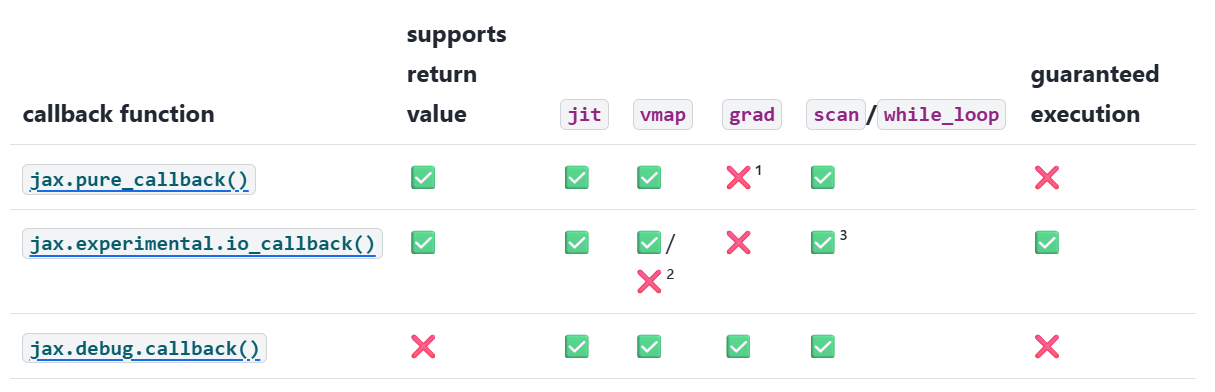

¹ jax.pure_callback can be used with custom_jvp to make it compatible with autodiff

² jax.experimental.io_callback is compatible with vmap only if ordered=False.

³ Note that vmap of scan/while_loop of io_callback has complicated semantics, and its behavior may change in future releases.

## Exploring pure_callback

jax.pure_callback() is generally the callback function you should reach for when you want host-side execution of a pure function: i.e. a function that has no side-effects (such as printing values, reading data from disk, updating a global state, etc.).

The function you pass to jax.pure_callback() need not actually be pure, but it will be assumed pure by JAX’s transformations and higher-order functions, which means that it may be silently elided or called multiple times.

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

def f_host(x):
  # call a numpy (not jax.numpy) operation:
  return np.sin(x).astype(x.dtype)

def f(x):
  result_shape = jax.ShapeDtypeStruct(x.shape, x.dtype)
  return jax.pure_callback(f_host, result_shape, x, vmap_method='sequential')

x = jnp.arange(5.0)
f(x)
# It's mapping

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

Because pure_callback can be elided or duplicated, it is compatible out-of-the-box with transformations like jit as well as higher-order primitives like scan and while_loop:”

In [4]:
jax.jit(f)(x)

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

In [5]:
def body_fun(_, x):
  return _, f(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

Because we specified a vmap_method in the pure_callback function call, it will also be compatible with vmap:

In [6]:
jax.vmap(f)(x)

Array([ 0.       ,  0.841471 ,  0.9092974,  0.14112  , -0.7568025],      dtype=float32)

However, because there is no way for JAX to introspect the content of the callback, pure_callback has undefined autodiff semantics:

In [7]:
jax.grad(f)(x)

ValueError: Pure callbacks do not support JVP. Please use `jax.custom_jvp` to use callbacks while taking gradients.

For an example of using pure_callback with jax.custom_jvp(), see Example: pure_callback with custom_jvp below.

By design functions passed to pure_callback are treated as if they have no side-effects: one consequence of this is that if the output of the function is not used, the compiler may eliminate the callback entirely:

In [8]:
def print_something():
  print('printing something')
  return np.int32(0)

@jax.jit
def f1():
  return jax.pure_callback(print_something, np.int32(0))
f1();

printing something


In [10]:
@jax.jit
def f2():
  jax.pure_callback(print_something, np.int32(0))
  return 1.0
f2();

In f1, the output of the callback is used in the return value of the function, so the callback is executed and we see the printed output. In f2 on the other hand, the output of the callback is unused, and so the compiler notices this and eliminates the function call. These are the correct semantics for a callback to a function with no side-effects.

## pure_callback and exceptions

In the context of JAX transformations, Python runtime exceptions should be considered side-effects: this means that intentionally raising an error within a pure_callback breaks the API contract, and the behavior of the resulting program is undefined. In particular, the manner in which such a program halts will generally depend on the backend, and the details of that behavior may change in future releases.

Additionally, passing impure functions to pure_callback may result in unexpected behavior during transformations like jax.jit() or jax.vmap(), because the transformation rules for pure_callback are defined under the assumption that the callback function is pure. Here’s one simple example of an impure callback behaving unexpectedly under vmap:

In [11]:
import jax
import jax.numpy as jnp

def raise_via_callback(x):
  def _raise(x):
    raise ValueError(f"value of x is {x}")
  return jax.pure_callback(_raise, x, x)

def raise_if_negative(x):
  return jax.lax.cond(x < 0, raise_via_callback, lambda x: x, x)

x_batch = jnp.arange(4)

[raise_if_negative(x) for x in x_batch]  # does not raise

jax.vmap(raise_if_negative)(x_batch)  # ValueError: value of x is 0

ERROR:2025-06-25 19:51:00,860:jax._src.callback:102: jax.pure_callback failed
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 100, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 77, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-11-909931494.py", line 6, in _raise
    raise ValueError(f"value of x is {x}")
ValueError: value of x is 0
ERROR:jax._src.callback:jax.pure_callback failed
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 100, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^

XlaRuntimeError: INTERNAL: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
  File "/tmp/ipython-input-11-909931494.py", line 16, in <cell line: 0>
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/api.py", line 1015, in vmap_f
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/linear_util.py", line 210, in call_wrapped
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/batching.py", line 604, in _batch_outer
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/batching.py", line 619, in _batch_inner
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/batching.py", line 339, in flatten_fun_for_vmap
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/linear_util.py", line 370, in _get_result_paths_thunk
  File "/tmp/ipython-input-11-909931494.py", line 10, in raise_if_negative
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lax/control_flow/conditionals.py", line 306, in cond
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lax/control_flow/conditionals.py", line 278, in _cond
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 502, in bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 520, in _true_bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 525, in bind_with_trace
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/batching.py", line 488, in process_primitive
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lax/control_flow/conditionals.py", line 398, in _cond_batching_rule
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 276, in jaxpr_as_fun
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 590, in eval_jaxpr
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 502, in bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 520, in _true_bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 525, in bind_with_trace
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 1024, in process_primitive
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/dispatch.py", line 90, in apply_primitive
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/pjit.py", line 341, in cache_miss
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/pjit.py", line 197, in _python_pjit_helper
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 502, in bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 520, in _true_bind
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 525, in bind_with_trace
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/core.py", line 1024, in process_primitive
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/pjit.py", line 1724, in _pjit_call_impl
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/pjit.py", line 1700, in call_impl_cache_miss
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/pjit.py", line 1679, in _pjit_call_impl_python
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/profiler.py", line 334, in wrapper
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/pxla.py", line 1287, in __call__
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 778, in _wrapped_callback
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 224, in _callback
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 103, in pure_callback_impl
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/callback.py", line 77, in __call__
  File "/tmp/ipython-input-11-909931494.py", line 6, in _raise
ValueError: value of x is 0

To avoid this and similar unexpected behavior, we recommend not attempting to use pure_callback to raise runtime errors.

## Exploring io_callback

In contrast to jax.pure_callback(), jax.experimental.io_callback() is explicitly meant to be used with impure functions, i.e. functions that do have side-effects.

As an example, here is a callback to a global host-side numpy random generator. This is an impure operation because a side-effect of generating a random number in numpy is that the random state is updated (Please note that this is meant as a toy example of io_callback and not necessarily a recommended way of generating random numbers in JAX!).

In [14]:
from jax.experimental import io_callback
from functools import partial

global_rng = np.random.default_rng(0)

def host_side_random_like(x):
  """Generate a random array like x using the global_rng state"""
  # We have two side-effects here:
  # - printing the shape and dtype
  # - calling global_rng, thus updating its state
  print(f'generating {x.dtype}{list(x.shape)}')
  return global_rng.uniform(size=x.shape).astype(x.dtype)

@jax.jit
def numpy_random_like(x):
  return io_callback(host_side_random_like, x, x)

x = jnp.zeros(5)
numpy_random_like(x)

generating float32[5]


Array([0.6369617 , 0.26978672, 0.04097353, 0.01652764, 0.8132702 ],      dtype=float32)

The io_callback is compatible with vmap by default:

In [15]:
jax.vmap(numpy_random_like)(x)

generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]


Array([0.91275555, 0.60663575, 0.72949654, 0.543625  , 0.9350724 ],      dtype=float32)

Note, however, that this may execute the mapped callbacks in any order. So, for example, if you ran this on a GPU, the order of the mapped outputs might differ from run to run.

If it is important that the order of callbacks be preserved, you can set ordered=True, in which case attempting to vmap will raise an error:

In [16]:
@jax.jit
def numpy_random_like_ordered(x):
  return io_callback(host_side_random_like, x, x, ordered=True)

jax.vmap(numpy_random_like_ordered)(x)

ValueError: Cannot `vmap` ordered IO callback.

On the other hand, scan and while_loop work with io_callback regardless of whether ordering is enforced:

In [17]:
def body_fun(_, x):
  return _, numpy_random_like_ordered(x)
jax.lax.scan(body_fun, None, jnp.arange(5.0))[1]

generating float32[]
generating float32[]
generating float32[]
generating float32[]
generating float32[]


Array([0.81585354, 0.0027385 , 0.8574043 , 0.03358557, 0.72965544],      dtype=float32)

Like pure_callback, io_callback fails under automatic differentiation if it is passed a differentiated variable:

In [18]:
jax.grad(numpy_random_like)(x)

ValueError: IO callbacks do not support JVP.

However, if the callback is not dependent on a differentiated variable, it will execute:

In [19]:
@jax.jit
def f(x):
  io_callback(lambda: print('hello'), None)
  return x

jax.grad(f)(1.0);

hello


Unlike pure_callback, the compiler will not remove the callback execution in this case, even though the output of the callback is unused in the subsequent computation.

## Exploring debug.callback

Both pure_callback and io_callback enforce some assumptions about the purity of the function they’re calling, and limit in various ways what JAX transforms and compilation machinery may do. debug.callback essentially assumes nothing about the callback function, such that the action of the callback reflects exactly what JAX is doing during the course of a program. Further, debug.callback cannot return any value to the program.

In [20]:
from jax import debug

def log_value(x):
  # This could be an actual logging call; we'll use
  # print() for demonstration
  print("log:", x)

@jax.jit
def f(x):
  debug.callback(log_value, x)
  return x

f(1.0);

log: 1.0


The debug callback is compatible with vmap:

In [21]:
x = jnp.arange(5.0)
jax.vmap(f)(x);

log: 0.0
log: 1.0
log: 2.0
log: 3.0
log: 4.0


And is also compatible with grad and other autodiff transformations

In [22]:
jax.grad(f)(1.0);

log: 1.0


This can make debug.callback more useful for general-purpose debugging than either pure_callback or io_callback.

# Example: pure_callback with custom_jvp

One powerful way to take advantage of jax.pure_callback() is to combine it with jax.custom_jvp. (Refer to Custom derivative rules for JAX-transformable Python functions for more details on jax.custom_jvp()).

Suppose you want to create a JAX-compatible wrapper for a scipy or numpy function that is not yet available in the jax.scipy or jax.numpy wrappers.

Here, we’ll consider creating a wrapper for the Bessel function of the first kind, available in scipy.special.jv. You can start by defining a straightforward pure_callback():

In [23]:
import jax
import jax.numpy as jnp
import scipy.special

def jv(v, z):
  v, z = jnp.asarray(v), jnp.asarray(z)

  # Require the order v to be integer type: this simplifies
  # the JVP rule below.
  assert jnp.issubdtype(v.dtype, jnp.integer)

  # Promote the input to inexact (float/complex).
  # Note that jnp.result_type() accounts for the enable_x64 flag.
  z = z.astype(jnp.result_type(float, z.dtype))

  # Wrap scipy function to return the expected dtype.
  _scipy_jv = lambda v, z: scipy.special.jv(v, z).astype(z.dtype)

  # Define the expected shape & dtype of output.
  result_shape_dtype = jax.ShapeDtypeStruct(
      shape=jnp.broadcast_shapes(v.shape, z.shape),
      dtype=z.dtype)

  # Use vmap_method="broadcast_all" because scipy.special.jv handles broadcasted inputs.
  return jax.pure_callback(_scipy_jv, result_shape_dtype, v, z, vmap_method="broadcast_all")

This lets us call into scipy.special.jv() from transformed JAX code, including when transformed by jit() and vmap():

In [25]:
from functools import partial
j1 = partial(jv, 1)
z = jnp.arange(5.0)
print(j1(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


Here is the same result with jit():

In [26]:
print(jax.jit(j1)(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


And here is the same result again with vmap():

In [27]:
print(jax.vmap(j1)(z))

[ 0.          0.44005057  0.5767248   0.33905897 -0.06604332]


However, if you call grad(), you will get an error because there is no autodiff rule defined for this function:

In [28]:
jax.grad(j1)(z)

ValueError: Pure callbacks do not support JVP. Please use `jax.custom_jvp` to use callbacks while taking gradients.

Let’s define a custom gradient rule for this. Looking at the definition of the Bessel Function of the First Kind, you find that there is a relatively straightforward recurrence relationship for the derivative with respect to the argument z:

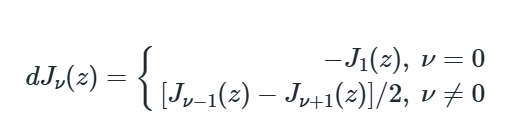

The gradient with respect to
 is more complicated, but since we’ve restricted the v argument to integer types you don’t need to worry about its gradient for the sake of this example.

You can use jax.custom_jvp() to define this automatic differentiation rule for your callback function:

In [29]:
jv = jax.custom_jvp(jv)

@jv.defjvp
def _jv_jvp(primals, tangents):
  v, z = primals
  _, z_dot = tangents  # Note: v_dot is always 0 because v is integer.
  jv_minus_1, jv_plus_1 = jv(v - 1, z), jv(v + 1, z)
  djv_dz = jnp.where(v == 0, -jv_plus_1, 0.5 * (jv_minus_1 - jv_plus_1))
  return jv(v, z), z_dot * djv_dz

Now computing the gradient of your function will work correctly:

In [30]:
j1 = partial(jv, 1)
print(jax.grad(j1)(2.0))

-0.06447162


Further, since we’ve defined your gradient in terms of jv itself, JAX’s architecture means that you get second-order and higher derivatives for free:

In [31]:
jax.hessian(j1)(2.0)

Array(-0.4003078, dtype=float32, weak_type=True)

Keep in mind that although this all works correctly with JAX, each call to your callback-based jv function will result in passing the input data from the device to the host, and passing the output of scipy.special.jv() from the host back to the device.

When running on accelerators like GPU or TPU, this data movement and host synchronization can lead to significant overhead each time jv is called.

However, if you are running JAX on a single CPU (where the “host” and “device” are on the same hardware), JAX will generally do this data transfer in a fast, zero-copy fashion, making this pattern a relatively straightforward way to extend JAX’s capabilities.